<a href="https://colab.research.google.com/github/ArifAygun/Iron-Ore-Froth-Flotation-Quality-Prediction/blob/main/AA_Graduate_Project_0531_GR_MODEL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Quality Prediction of Iron Ore Mining Flotation Process - Part:2**

## **5. Modelling**

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from google.colab import drive

drive.mount('/content/drive/')
%cd /content/drive/My Drive/Flotation/

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/Flotation


In [3]:
flotation = pd.read_csv('Flotation_Plant_Clean.csv')
flotation.head().T

,0,1,2,3,4
date,2017-03-10 01:00:00,2017-03-10 01:00:00,2017-03-10 01:00:00,2017-03-10 01:00:00,2017-03-10 01:00:00
iron_feed,55.2,55.2,55.2,55.2,55.2
silica_feed,16.98,16.98,16.98,16.98,16.98
starch_flow,301.953,302.441,304.346,304.736,303.369
amina_flow,557.434,563.965,568.054,568.665,558.167
pulp_flow,395.713,397.383,399.668,397.939,400.254
pulp_pH,10.07,10.07,10.07,10.07,10.07
pulp_density,1.74,1.74,1.74,1.74,1.74
airflow_col1,249.214,249.719,249.741,249.917,250.203
airflow_col2,253.235,250.532,247.874,254.487,252.136


In [4]:
flotation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 726453 entries, 0 to 726452
Data columns (total 24 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   date          726453 non-null  object 
 1   iron_feed     726453 non-null  float64
 2   silica_feed   726453 non-null  float64
 3   starch_flow   726453 non-null  float64
 4   amina_flow    726453 non-null  float64
 5   pulp_flow     726453 non-null  float64
 6   pulp_pH       726453 non-null  float64
 7   pulp_density  726453 non-null  float64
 8   airflow_col1  726453 non-null  float64
 9   airflow_col2  726453 non-null  float64
 10  airflow_col3  726453 non-null  float64
 11  airflow_col4  726453 non-null  float64
 12  airflow_col5  726453 non-null  float64
 13  airflow_col6  726453 non-null  float64
 14  airflow_col7  726453 non-null  float64
 15  level_col1    726453 non-null  float64
 16  level_col2    726453 non-null  float64
 17  level_col3    726453 non-null  float64
 18  leve

In [10]:
flotation.shape

(726453, 24)

### **5.1. Grouping Rows with Hourly Frequency**

The importance of considering plant data as a holistic entity was emphasized in order to gain a comprehensive understanding. To achieve this, a loop-based analysis methodology was employed. Each row of data was treated as an individual iteration, representing a complete cycle of feeding 100 tons of ore to the plant, enriching it, and concluding the process. For the purpose of this study, each cycle was set at a duration of one hour. Consequently, a photograph of the plant was captured at hourly intervals and subjected to analysis. It is worth noting that if a more frequent and regular data collection scheme were in place, such as cycles occurring every minute, it would yield a larger dataset suitable for machine learning applications.

In [11]:
flotation['date'] = pd.to_datetime(flotation['date'])
#grouping the data according to the hours and get their average values. 
flotation_grouped = flotation.groupby(pd.Grouper(key='date',freq='H')).mean()
# cycle_data.insert(0,'Date',cycle_data.index)
flotation_grouped.reset_index(inplace = True)

#some rows have 'null' values because of timing. We need to drop them 
print('Shape of Grouped Flotation Dataset = ', flotation_grouped.shape)
cycle_data = flotation_grouped.dropna()
print('Shape of Grouped Flotation Dataset after drop null values = ', flotation_grouped.shape)

Shape of Grouped Flotation Dataset =  (4415, 24)
Shape of Grouped Flotation Dataset after drop null values =  (4415, 24)


The grouping process has a number of advantages and disadvantages.

**Advantages:**
Each analysis will be able to do each data cycle on an hourly frequency.
Date column can be dropped. The number of columns fell to 23.
The number of rows fell to 4097 from 737453. Every rows means calculations on computer.

**Disadvantage:** The number of rows fell to 4097 from 737453. The more rows we have for machine learning, the better results we get. This large data loss will adversely affect our estimation results.

### **5.2. Divide Data**

Flotation plant product (at least for this missing data) Iron and Silica concentrates namely the last two columns. We will develop separate models for silica and iron in machine learning, so we will separate the columns from the main data as two data types named "iron_concentrate" and "silica_concentrate". The remaining columns are essentially Flotation conditions required to enrich the concentrate. We also separate them as "flotation_conditions".

In [ ]:
#seperate data as flotation_conditions and concentrates
flotation_conditions = flotation.iloc[:,1:22]
concentrates = flotation.iloc[:,22:]
silica_concentrate = concentrates.iloc[:,1].values
iron_concentrate = concentrates.iloc[:,0].values

print('Shape of flotation_conditions = ', flotation_conditions.shape)
print('Shape of silica_concentrate = ', silica_concentrate.shape)
print('Shape of iron_concentrate = ', iron_concentrate.shape)

Shape of flotation_conditions =  (726453, 21)
Shape of silica_concentrate =  (726453,)
Shape of iron_concentrate =  (726453,)



## **6. Modeling**

### **6.1. P-Value**

In [ ]:
import statsmodels.api as sm

b_zero = np.append(arr = np.ones((len(flotation.iloc[:,1].values),1)).
                   astype(int), values = flotation_conditions, axis = 1)

silica_concentrate = concentrates.iloc[:,1].values
iron_concentrate = concentrates.iloc[:,0].values

model_iron = sm.OLS(endog = iron_concentrate,exog = b_zero).fit()
print(model_iron.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.139
Model:                            OLS   Adj. R-squared:                  0.139
Method:                 Least Squares   F-statistic:                     5563.
Date:                Thu, 01 Jun 2023   Prob (F-statistic):               0.00
Time:                        00:09:59   Log-Likelihood:            -1.0581e+06
No. Observations:              726453   AIC:                         2.116e+06
Df Residuals:                  726431   BIC:                         2.116e+06
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         53.2526      0.247    215.581      0.0

In [ ]:
model_silica = sm.OLS(endog = silica_concentrate,exog = b_zero).fit()
print(model_silica.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.152
Model:                            OLS   Adj. R-squared:                  0.152
Method:                 Least Squares   F-statistic:                     6196.
Date:                Thu, 01 Jun 2023   Prob (F-statistic):               0.00
Time:                        00:10:00   Log-Likelihood:            -1.0571e+06
No. Observations:              726453   AIC:                         2.114e+06
Df Residuals:                  726431   BIC:                         2.115e+06
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.4616      0.247     18.086      0.0

In [ ]:
#extract p-value from regression results
pValue_fe = model_iron.pvalues
pValue_si = model_silica.pvalues
pValue_fe_list = []
pValue_si_list = []
for i in range(len(pValue_fe)):
    if i > 0:
        pValue_fe_list.append(pValue_fe[i])
        pValue_si_list.append(pValue_si[i])

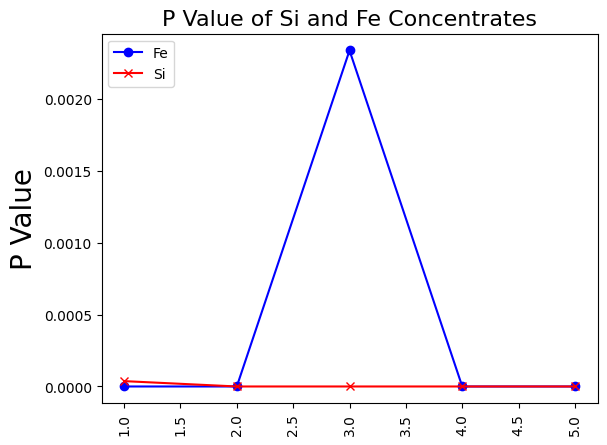

In [ ]:
import matplotlib.pyplot as plt

fe = pValue_fe_list[:5]  # Take the first 5 elements of the 'fe' list
si = pValue_si_list[:5]  # Take the first 5 elements of the 'si' list
t = [1, 2, 3, 4, 5]  # Replace with the appropriate time or x-axis values corresponding to 'fe' and 'si'
plt.plot(t, fe, label='Fe', color='blue', marker='o')
plt.plot(t, si, label='Si', color='red', marker='x')
plt.xticks(rotation=90)

plt.legend(loc="upper left", prop={"size": 10})
plt.ylabel('P Value', fontsize=20)
plt.title('P Value of Si and Fe Concentrates', fontsize=16)

plt.show()


When we examine the P values, we see that some values do not affect the concentrated grades. But now we know that this is due to our lack of data. What would you think if you saw that the cocoa had no effect on the chocolate produced in the chocolate factory?

### **6.2. Confidence Interval**

In [ ]:
import math

m_fe = iron_concentrate.mean()
se_fe = iron_concentrate.std() / math.sqrt(len(iron_concentrate))
ci_fe = [m_fe - se_fe * 1.96, m_fe + se_fe * 1.96]

m_si = silica_concentrate.mean()
se_si = silica_concentrate.std() / math.sqrt(len(silica_concentrate))
ci_si = [m_si - se_si * 1.96, m_si + se_si * 1.96]

print('Confidence interval of Fe Concentrate:', ci_fe)
print('Confidence interval of Silica Concentrate:', ci_si)


Confidence interval of Fe Concentrate: [65.04622387898222, 65.05136889026788]
Confidence interval of Silica Concentrate: [2.3248525326690723, 2.3300310179529253]


Metallurgical engineers apply the pouring process to the concentrate we sell and obtain pure iron. There is a grade range they demand from us for this operation: %67 – 68 Fe Grade %1.6 – 1.7 Si Grade In the model we developed according to the confidence interval, the silica values are more than demanded. In the first stage, we need to warn the engineers in the field. (Assuming our data is reliable.)


## **7. Evaluation**

### **7.1. R-squared in Regression Analysis**

In [ ]:
flotation.columns

Index(['date', 'iron_feed', 'silica_feed', 'starch_flow', 'amina_flow',
       'pulp_flow', 'pulp_pH', 'pulp_density', 'airflow_col1', 'airflow_col2',
       'airflow_col3', 'airflow_col4', 'airflow_col5', 'airflow_col6',
       'airflow_col7', 'level_col1', 'level_col2', 'level_col3', 'level_col4',
       'level_col5', 'level_col6', 'level_col7', 'iron_conc', 'silica_conc'],
      dtype='object')

In [ ]:
import statsmodels.api as sm

# Assuming you have a DataFrame named 'df' with the required columns
endog = flotation['silica_conc']  # Define your endogenous variable
exog = flotation[['iron_feed', 'silica_feed', 'starch_flow', 'amina_flow',
           'pulp_flow', 'pulp_pH', 'pulp_density', 'airflow_col1', 'airflow_col2',
           'airflow_col3', 'airflow_col4', 'airflow_col5', 'airflow_col6',
           'airflow_col7', 'level_col1', 'level_col2', 'level_col3', 'level_col4',
           'level_col5', 'level_col6', 'level_col7']]  # Define your exogenous variables

model = sm.OLS(endog, exog)
results = model.fit()

# Get the R-squared value
r_squared = results.rsquared

print("R-squared:", r_squared)



R-squared: 0.8390858890738184


The calculated R-squared value of 0.839 suggests that approximately 83.9% of the variability in the dependent variable (silica_concentrate) can be explained by the independent variables.

A high R-squared value indicates a good fit of the model to the data, suggesting that the independent variables are strongly associated with the variation in the dependent variable. However, it's important to interpret the R-squared value in the context of your specific problem and the field of study. Other factors, such as the significance of individual coefficients and the presence of multicollinearity, should also be considered.

In summary, based on the given model and data, the R-squared value of 0.839 indicates a relatively strong relationship between the independent variables and the silica_concentrate, suggesting that the model captures a significant portion of the variability in the target variable.

### **7.2. Multi Linear Regression Analysis**

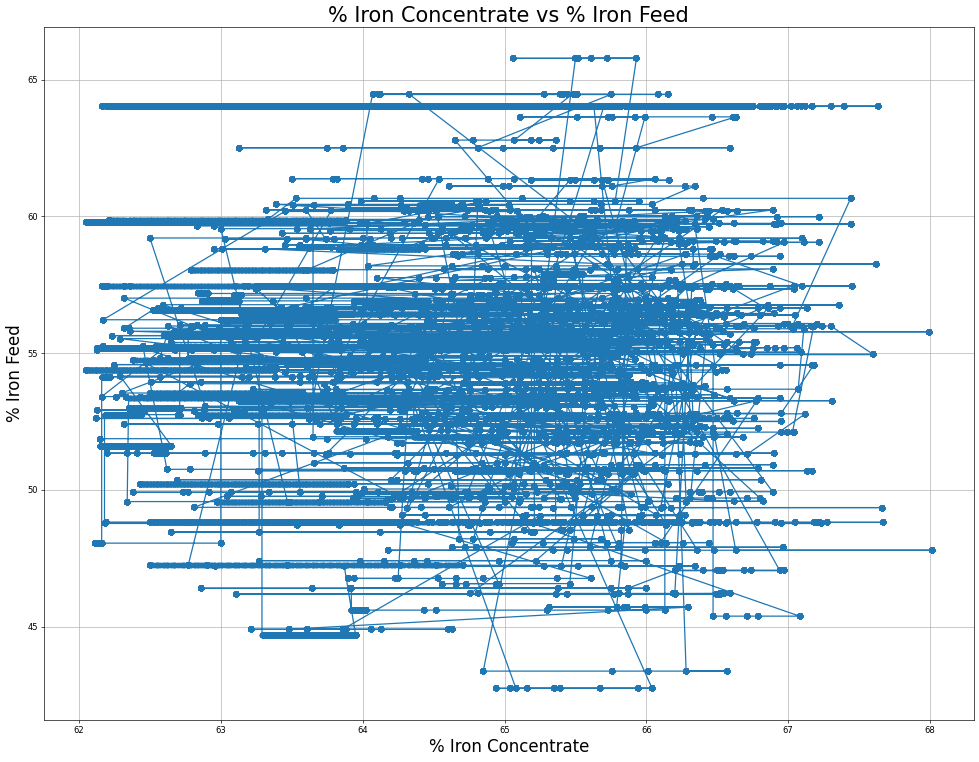

In [ ]:
import matplotlib.pyplot as plt

width = 20
height = 15
dots = 60

plt.figure(figsize=(width, height), dpi=dots)

x_axis = flotation['iron_conc']
y_axis = flotation['iron_feed']
plt.plot(x_axis, y_axis, marker='o', label='% Iron Concentrate vs % Iron Feed')
plt.xticks()
plt.xlabel('% Iron Concentrate', fontsize=20)
plt.ylabel('% Iron Feed', fontsize=20)
plt.title('% Iron Concentrate vs % Iron Feed', fontsize=25)
plt.grid(True)
plt.show()


As you can see in plot, there is no Linear Reletionship betweenn Iron Feed and Iron Concentration, this is just example. The other columns relation ships are same. I am waiting for a low result of R2-Score from Multi Linear Regression Analysis

In [ ]:
#train test split for regression training and testing 
x_train, x_test, y_train, y_test = train_test_split(flotation_conditions,
                                                    concentrates,
                                                    test_size = 0.15,
                                                    random_state = 0)

In [ ]:
from sklearn.metrics import r2_score


regressor_mlr = LinearRegression()
regressor_mlr.fit(x_train,y_train) #x trainden y traini öğren 

y_pred_mlr = regressor_mlr.predict(x_test)
print('R2 Score of Multi Linear Regression',r2_score(y_test,y_pred_mlr))

R2 Score of Multi Linear Regression 0.14871545386829182


It has become clear that the Multi Linear Regression model cannot be used. I will focus on Random Forest machine learning model development.

In [ ]:
X_train.shape


NameError: ignored

### **7.3. Random Forest Regressor**

The first time I divided the data as train test split at 0.33 degree and applied Random Forest machine learning, but I got very low r-Square values. Finally, I used all the data for training and got the following results. Despite the lack of data, the result is satisfactory.

- Random Forest with Train-Test Split

In [ ]:
regressor_randForest = RandomForestRegressor(random_state = 0, n_estimators = 100)  
regressor_randForest.fit(x_train,y_train) 
y_pred_rf = regressor_randForest.predict(x_test)

regressor_randForest2 = RandomForestRegressor(random_state = 0, n_estimators = 100)  
regressor_randForest2.fit(flotation_conditions,concentrates)
y_pred_rf2 = regressor_randForest.predict(flotation_conditions)
 
print('R2 Score of Random Forest Regression with Train-Test Split',r2_score(y_test,y_pred_rf))
print('R2 Score of Random Forest Regression with Whole Data',r2_score(concentrates,y_pred_rf2))

As I mentioned before I divided concentrations and again applied Random Forest separately to Iron and Silica Concentration grades. R2-Score result is marvelous.

- Iron Random Forest Model

In [ ]:
regressor_Fe = RandomForestRegressor(random_state = 0, n_estimators = 100)  
regressor_Fe.fit(flotation_conditions,iron_concentrate) 
y_pred_Fe = regressor_Fe.predict(flotation_conditions)

print('R2 Score of Random Forest Regression with Only Iron',r2_score(iron_concentrate,y_pred_Fe))

- Silica Random Forest Model

In [ ]:
regressor_Si = RandomForestRegressor(random_state = 0, n_estimators = 100)  
regressor_Si.fit(flotation_conditions,silica_concentrate) 
y_pred_Si = regressor_Si.predict(flotation_conditions)

print('R2 Score of Random Forest Regression with Only Silica',r2_score(silica_concentrate,y_pred_Si))


## **8.  Deployment**

### **8.1. First Prediction**

In [ ]:
#feel free change values and see results
predictions = {'% Iron Feed':50.5,
          '% Silica Feed':13.3,
          'Starch Flow':3500.0,
          'Amina Flow':580.0,
          'Ore Pulp Flow':400.0,
          'Ore Pulp pH':10.11,
          'Ore Pulp Density':1.69,
          'Flotation Column 01 Air Flow':250.0,
          'Flotation Column 02 Air Flow':150.0,
          'Flotation Column 03 Air Flow':270.0,
          'Flotation Column 04 Air Flow':190.0,
          'Flotation Column 05 Air Flow':230.0,
          'Flotation Column 06 Air Flow':200.0,
          'Flotation Column 07 Air Flow':240.0,
          'Flotation Column 01 Level':480,
          'Flotation Column 02 Level':210.0,
          'Flotation Column 03 Level':550.0,
          'Flotation Column 04 Level':620.0,
          'Flotation Column 05 Level':610.0,
          'Flotation Column 06 Level':615.0,
          'Flotation Column 07 Level':616.0,
          }

In [ ]:
#to see predictions, run this code
predict_values = []
for value in predictions.values(): 
    predict_values.append(value)

predict_Fe = regressor_Fe.predict([predict_values])
predict_Si = regressor_Si.predict([predict_values])

print('Predicted Fe Concentrate =',predict_Fe,'%')
print('Predicted Silica Concentrate =',predict_Si,'%')

### **8.2. Second Prediction**

- I will feed to ML mean values of the main data and demand to predict concentrate values.

In [ ]:
predict_from_means = flotation_conditions.describe().mean()
predict_Fe = regressor_Fe.predict([predict_from_means])
predict_Si = regressor_Si.predict([predict_from_means])

print('Predicted Fe Concentrate from Conditions mean  =',predict_Fe,'%')
print('Predicted Silica Concentrate from Conditions mean =',predict_Si,'%')

We obtained the values we determined in the Confidence Intervals. The results are also very close to the average tenor values. After all, we have a working ML application.


## **9. Conclusion**

With the analysis made over the same data set, we can write thousands more questions and get results.
Our touchstone data on the road to IoT (internet of things) and how we store them. As long as we take care of our data and enrich them, the future is not far away. The more data you get, the more accurate results are inevitable.

Artificial intelligence, which analyzes the ore coming from the mine and gives us the facility parameters as ready and calculate equipment maintenance possibilities, is now very close.

In [ ]:
flotation.columns

### **5.3. Split train, val and test**

- splitting the data into training, validation and test set
- training set will be used to train the models
- validation set will be used to choose the mode
- test set will be used to check the performance of the chosen model on new data

In [ ]:
X = flotation.iloc[:, 0:21]
y = flotation.iloc[:, 21:]

X_train, X_, y_train, y_ = train_test_split(X, y, train_size=0.6, random_state=42, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_, y_, test_size=0.5, random_state=42)
print(f'The shape of X_train is {X_train.shape}\nThe shape of X_val is {X_val.shape}\nThe shape of X_test is {X_test.shape}\nThe shape of y_train is {y_train.shape}\nThe shape of y_val is {y_val.shape}\nThe shape of y_test is {y_test.shape}')

**scale/normalize the training data (z-score normalization)**

- To prevent any information about the distribution of the test set from influencing the model, the training data will be scaled using z-score normalization. 
- This approach ensures that the scaling transformation is applied solely based on the training data. 
- Consequently, the scaler will be fitted exclusively on the training set, and subsequently, the training, validation, and test sets will be standardized using the fitted scaler. 
- By adhering to this procedure, the integrity of the model evaluation on new, unseen data is maintained, without any potential leakage of information from the test set.

In [ ]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_val = sc.transform(X_val)
X_test = sc.transform(X_test)

The goal is to create models that outperform the dummy regressor. 

### **5.4. Linear regression**

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Create an instance of the LinearRegression model
lin_reg = LinearRegression()

# Fit the model on the training data
lin_reg.fit(X_train, y_train)

# Make predictions on the validation set
y_val_pred = lin_reg.predict(X_val)

# Calculate the mean squared error on the validation set
mse = mean_squared_error(y_val, y_val_pred)
print(f"Mean Squared Error on the validation set: {mse}")

# Evaluate the model on the test set
y_test_pred = lin_reg.predict(X_test)
mse_test = mean_squared_error(y_test, y_test_pred)
print(f"Mean Squared Error on the test set: {mse_test}")


- Linear Regression model performs better than dummy regressor, 
- Check the performance of another models.

### **5.5. Lasso regression**

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

# Create a Lasso regression model
lasso_reg = Lasso(alpha=0.1)

# Fit the model on the training data
lasso_reg.fit(X_train, y_train)

# Make predictions on the validation set
y_val_pred = lasso_reg.predict(X_val)

# Calculate the mean squared error on the validation set
mse = mean_squared_error(y_val, y_val_pred)
print(f"Mean Squared Error on the validation set: {mse}")

# Evaluate the model on the test set
y_test_pred = lasso_reg.predict(X_test)
mse_test = mean_squared_error(y_test, y_test_pred)
print(f"Mean Squared Error on the test set: {mse_test}")


### **5.7. Ridge regression**

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

# Create a Ridge regression model
ridge_reg = Ridge(alpha=0.1)

# Fit the model on the training data
ridge_reg.fit(X_train, y_train)

# Make predictions on the validation set
y_val_pred = ridge_reg.predict(X_val)

# Calculate the mean squared error on the validation set
mse = mean_squared_error(y_val, y_val_pred)
print(f"Mean Squared Error on the validation set: {mse}")

# Evaluate the model on the test set
y_test_pred = ridge_reg.predict(X_test)
mse_test = mean_squared_error(y_test, y_test_pred)
print(f"Mean Squared Error on the test set: {mse_test}")


### **5.8. ElasticNet Regression**

In [ ]:
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error

# Create an instance of the ElasticNet regression model
elastic_net = ElasticNet(alpha=1.0, l1_ratio=0.5)  # You can adjust the alpha and l1_ratio values

# Fit the model on the training data
elastic_net.fit(X_train, y_train)

# Make predictions on the validation set
y_val_pred = elastic_net.predict(X_val)

# Calculate the mean squared error on the validation set
mse = mean_squared_error(y_val, y_val_pred)
print(f"Mean Squared Error on the validation set: {mse}")

# Evaluate the model on the test set
y_test_pred = elastic_net.predict(X_test)
mse_test = mean_squared_error(y_test, y_test_pred)
print(f"Mean Squared Error on the test set: {mse_test}")


### **5.9. AdaBoost Regression**

In [ ]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error

# Create an instance of the AdaBoost regression model
adaboost_reg = AdaBoostRegressor(n_estimators=100, random_state=42)  # You can adjust the n_estimators parameter

# Fit the model on the training data
adaboost_reg.fit(X_train, y_train)

# Make predictions on the validation set
y_val_pred = adaboost_reg.predict(X_val)

# Calculate the mean squared error on the validation set
mse = mean_squared_error(y_val, y_val_pred)
print(f"Mean Squared Error on the validation set: {mse}")

# Evaluate the model on the test set
y_test_pred = adaboost_reg.predict(X_test)
mse_test = mean_squared_error(y_test, y_test_pred)
print(f"Mean Squared Error on the test set: {mse_test}")


### **5.8. Stochastic Gradient Descent Regressor**

In [ ]:
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error

# Create an instance of the SGD regression model
sgd_reg = SGDRegressor(random_state=42)

# Fit the model on the training data
sgd_reg.fit(X_train, y_train)

# Make predictions on the validation set
y_val_pred = sgd_reg.predict(X_val)

# Calculate the mean squared error on the validation set
mse = mean_squared_error(y_val, y_val_pred)
print(f"Mean Squared Error on the validation set: {mse}")

# Evaluate the model on the test set
y_test_pred = sgd_reg.predict(X_test)
mse_test = mean_squared_error(y_test, y_test_pred)
print(f"Mean Squared Error on the test set: {mse_test}")


### **5.9. Support Vector Regression (SVR)**

In [ ]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

# Create an instance of the SVR model
svr = SVR()

# Fit the model on the training data
svr.fit(X_train, y_train)

# Make predictions on the validation set
y_val_pred = svr.predict(X_val)

# Calculate the mean squared error on the validation set
mse = mean_squared_error(y_val, y_val_pred)
print(f"Mean Squared Error on the validation set: {mse}")

# Evaluate the model on the test set
y_test_pred = svr.predict(X_test)
mse_test = mean_squared_error(y_test, y_test_pred)
print(f"Mean Squared Error on the test set: {mse_test}")


### **5.10. Decision Tree Regression**

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

# Create an instance of the DecisionTreeRegressor model
dt_reg = DecisionTreeRegressor()

# Fit the model on the training data
dt_reg.fit(X_train, y_train)

# Make predictions on the validation set
y_val_pred = dt_reg.predict(X_val)

# Calculate the mean squared error on the validation set
mse = mean_squared_error(y_val, y_val_pred)
print(f"Mean Squared Error on the validation set: {mse}")

# Evaluate the model on the test set
y_test_pred = dt_reg.predict(X_test)
mse_test = mean_squared_error(y_test, y_test_pred)
print(f"Mean Squared Error on the test set: {mse_test}")


### **5.9. Random Forest Regressor**

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Create a Random Forest regression model
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model on the training data
rf_reg.fit(X_train, y_train)

# Make predictions on the validation set
y_val_pred = rf_reg.predict(X_val)

# Calculate the mean squared error on the validation set
mse = mean_squared_error(y_val, y_val_pred)
print(f"Mean Squared Error on the validation set: {mse}")

# Evaluate the model on the test set
y_test_pred = rf_reg.predict(X_test)
mse_test = mean_squared_error(y_test, y_test_pred)
print(f"Mean Squared Error on the test set: {mse_test}")


In [ ]:
comparison = pd.DataFrame({'Model': ['Linear Regression', 'SGDRegressor', 'Random Forest'],
                           'RMSE': [ sgd_rmse, rf_rmse]}, columns = ['Model', 'RMSE'])
comparison

- Among the models evaluated, the Random Forest model demonstrates the lowest RMSE value of 0.245278, indicating that it has the smallest average prediction error compared to the other models. This suggests that the Random Forest model performs the best in terms of minimizing the discrepancy between predicted and actual values.

- Both the Linear Regression and SGDRegressor models show relatively higher RMSE values of 1.037639 and 1.038636, respectively. This implies that these models have larger prediction errors compared to the Random Forest model.

- Based on these results, it can be concluded that the Random Forest model is the most effective in predicting the target variable, as it yields the lowest RMSE among the evaluated models.

In [ ]:
importance = rf.feature_importances_
for i,v in enumerate(importance):
 print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

- This graph displays the feature importance scores for each feature in the Random Forest model. The feature importance scores indicate the relative contribution of each feature in predicting the target variable.

- The results show that feature 1 has the highest importance score of 0.12523, followed by feature 5 with a score of 0.11926. These two features appear to have the most significant impact on the model's predictions.

- On the other hand, features 13, 8, 17, and 20 have the lowest importance scores, indicating that they contribute relatively less to the model's predictive power.

- Understanding the feature importance can provide insights into the underlying relationships between the input features and the target variable. It can guide feature selection, help identify key variables driving predictions, and aid in interpreting the model's behavior.

### **Hyperparameter tuning**

**Randomized search**

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 20, stop = 80, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 30, num = 3)]
# Minimum number of samples required to split a node
min_samples_split = [5, 10]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split}
print(random_grid)

In [ ]:
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, 
                               verbose=2, random_state=42, n_jobs = -1, scoring='neg_root_mean_squared_error')
# Fit the random search model
rf_random.fit(X_train, y_train)